In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Optional: visualize or inspect
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("final_processed_dataset.csv")
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.")
df.head(0)


Loaded dataset with 558 rows and 46 columns.


,ZIP,Metro,CountyName,StateSizeRank,FinalZHVI,FinalZScore,ZHVI_Tier,YoY_2001,YoY_2002,YoY_2003,...,Pct_Bachelors_Or_Higher,Unemployment_Rate,Pct_Below_Poverty,Pct_No_Vehicle,Pct_One_Person_HH,Pct_4plus_HH,Pct_Age_0_17,Pct_Age_18_34,Pct_Age_65plus,YoY_2025


In [2]:
# copy dataframe for modeling
df_model = df.copy()

# drop ZIP (just an ID)
df_model.drop(columns=["ZIP"], inplace=True)

# drop rows where target is missing
df_model = df_model[df_model["YoY_2025"].notna()]

# encode ZHVI_Tier as ordinal
zhvi_tier_mapping = {
    "very low": 0,
    "low": 1,
    "mid": 2,
    "high": 3,
    "very high": 4
}
df_model["ZHVI_Tier"] = df_model["ZHVI_Tier"].map(zhvi_tier_mapping)

# group rare categories in City/Metro/CountyName to 'Other'
def group_rare(series, min_count=2):
    counts = series.value_counts()
    return series.apply(lambda x: x if counts[x] >= min_count else "Other")

df_model["Metro"] = group_rare(df_model["Metro"])
df_model["CountyName"] = group_rare(df_model["CountyName"])

# one-hot encode location columns
df_model = pd.get_dummies(df_model, columns=["Metro", "CountyName"], drop_first=True)


In [3]:
# drop YoY columns before 2017
yoy_cols_to_drop = [col for col in df_model.columns if col.startswith("YoY_") and int(col.split("_")[1]) < 2017]
df_model.drop(columns=yoy_cols_to_drop, inplace=True)

# separate target from features
y = df_model["YoY_2025"]
X = df_model.drop(columns=["YoY_2025"])

# drop rows with missing values
rows_before = X.shape[0]
X = X.dropna()
y = y.loc[X.index]  # keep target in sync
print(f"✅ Dropped {rows_before - X.shape[0]} rows with missing values")
X.head(0)


✅ Dropped 51 rows with missing values


,StateSizeRank,FinalZHVI,FinalZScore,ZHVI_Tier,YoY_2017,YoY_2018,YoY_2019,YoY_2020,YoY_2021,YoY_2022,...,CountyName_Walker County,CountyName_Walton County,CountyName_Ware County,CountyName_Washington County,CountyName_Wayne County,CountyName_Wheeler County,CountyName_Whitfield County,CountyName_Wilkes County,CountyName_Wilkinson County,CountyName_Worth County


In [4]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# scale features (especially for similarity/error-based models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data split and scaled. Ready for feature selection and modeling.")


✅ Data split and scaled. Ready for feature selection and modeling.


In [5]:
# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# f_regression (linear relationships)
selector_f = SelectKBest(score_func=f_regression, k=21)
X_train_f = selector_f.fit_transform(X_train_scaled, y_train)
X_test_f = selector_f.transform(X_test_scaled)
selected_features_f = X.columns[selector_f.get_support()]
print("Top 21 features (f_regression):")
print(selected_features_f.tolist())

# mutual_info_regression (nonlinear relationships)
selector_mi = SelectKBest(score_func=mutual_info_regression, k=21)
X_train_mi = selector_mi.fit_transform(X_train_scaled, y_train)
X_test_mi = selector_mi.transform(X_test_scaled)
selected_features_mi = X.columns[selector_mi.get_support()]
print("\nTop 21 features (mutual_info_regression):")
print(selected_features_mi.tolist())

# optional: view overlap between methods
shared_features = set(selected_features_f) & set(selected_features_mi)
print(f"\nShared features between both methods ({len(shared_features)}):")
print(sorted(shared_features))


Top 21 features (f_regression):
['StateSizeRank', 'YoY_2017', 'YoY_2018', 'YoY_2021', 'YoY_2023', 'YoYGrowthVolatility', 'Pct_Renter_Occupied', 'Pct_Bachelors_Or_Higher', 'Pct_No_Vehicle', 'Pct_One_Person_HH', 'Pct_4plus_HH', 'Metro_Atlanta-Sandy Springs-Alpharetta, GA', 'Metro_Eufaula, AL-GA', 'Metro_Statesboro, GA', 'CountyName_Clayton County', 'CountyName_Dekalb County', 'CountyName_Emanuel County', 'CountyName_Fulton County', 'CountyName_Henry County', 'CountyName_Tattnall County', 'CountyName_Wheeler County']

Top 21 features (mutual_info_regression):
['StateSizeRank', 'FinalZHVI', 'FinalZScore', 'YoY_2017', 'YoY_2018', 'YoY_2019', 'YoY_2020', 'YoY_2021', 'YoY_2022', 'YoY_2023', 'YoY_2024', 'AvgYoYGrowth', 'YoYGrowthVolatility', 'NegativeGrowthYears', 'Pct_Renter_Occupied', 'Pct_Below_Poverty', 'Pct_No_Vehicle', 'Pct_One_Person_HH', 'Pct_4plus_HH', 'Metro_Atlanta-Sandy Springs-Alpharetta, GA', 'CountyName_Fulton County']

Shared features between both methods (12):
['CountyName_Ful

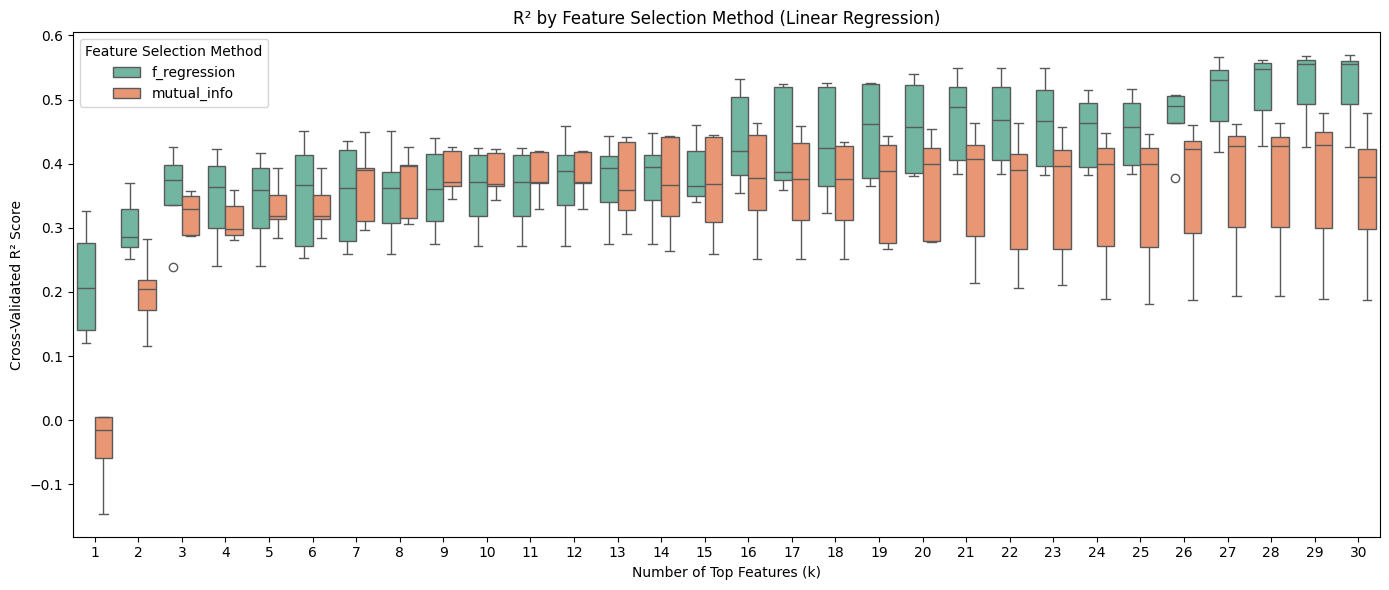

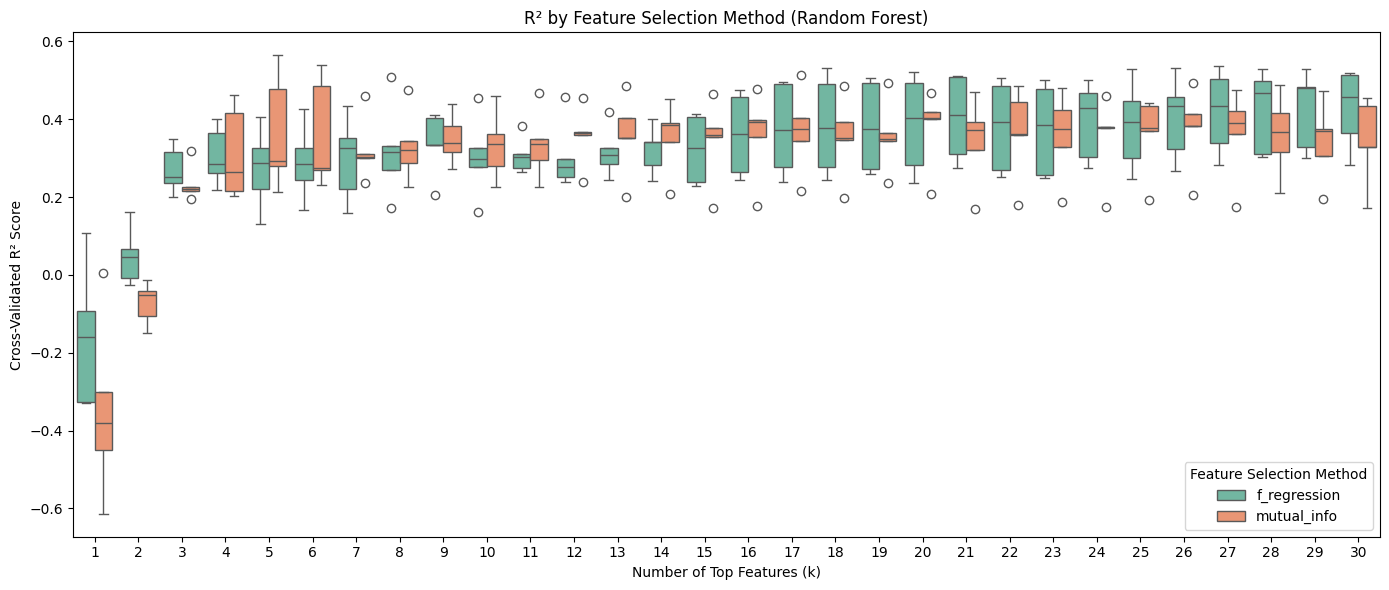

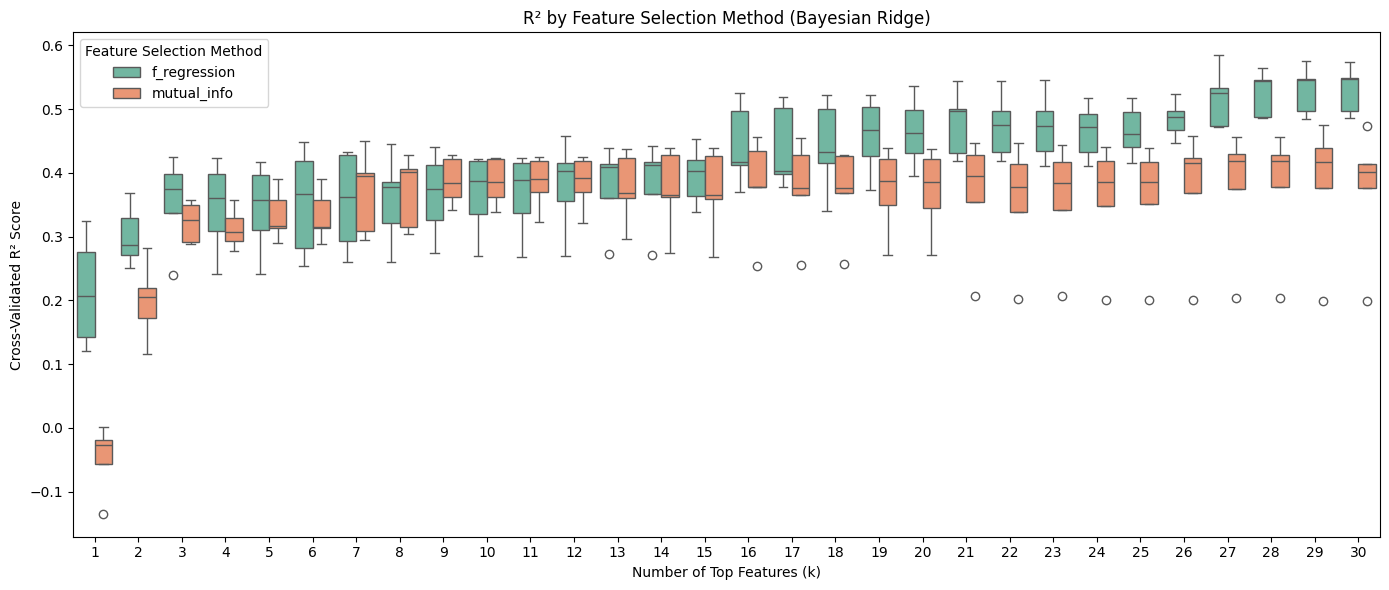

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# settings
max_k = 30
k_range = range(1, max_k + 1)

# model dictionary (no KNN, now using Bayesian Ridge instead)
models = {
    "Linear Regression": LinearRegression,
    "Random Forest": RandomForestRegressor,
    "Bayesian Ridge": BayesianRidge
}

# loop through models
for model_name, model_class in models.items():
    plot_data = []

    for k in range(1, max_k + 1):
        # f_regression
        sel_f = SelectKBest(score_func=f_regression, k=k)
        X_k_f = sel_f.fit_transform(X_train_scaled, y_train)
        model = model_class()
        scores = cross_val_score(model, X_k_f, y_train, cv=5, scoring="r2")
        for score in scores:
            plot_data.append({
                "R²": score, "k": k,
                "Method": "f_regression"
            })

        # mutual_info
        sel_mi = SelectKBest(score_func=mutual_info_regression, k=k)
        X_k_mi = sel_mi.fit_transform(X_train_scaled, y_train)
        model = model_class()
        scores = cross_val_score(model, X_k_mi, y_train, cv=5, scoring="r2")
        for score in scores:
            plot_data.append({
                "R²": score, "k": k,
                "Method": "mutual_info"
            })

    # create DataFrame and plot
    plot_df = pd.DataFrame(plot_data)

    plt.figure(figsize=(14, 6))
    sns.boxplot(data=plot_df, x="k", y="R²", hue="Method", palette="Set2")
    plt.title(f"R² by Feature Selection Method ({model_name})")
    plt.xlabel("Number of Top Features (k)")
    plt.ylabel("Cross-Validated R² Score")
    plt.legend(title="Feature Selection Method")
    plt.tight_layout()
    plt.show()


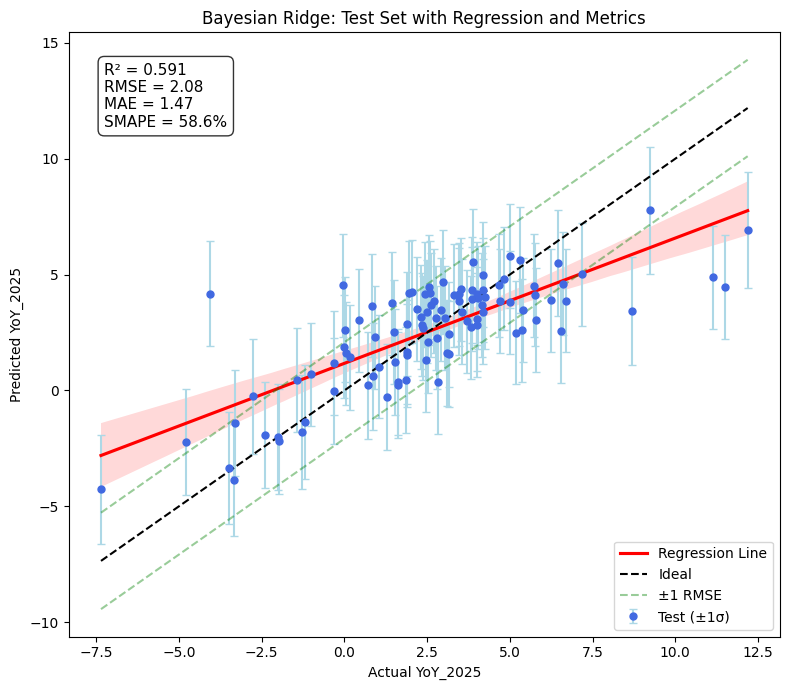

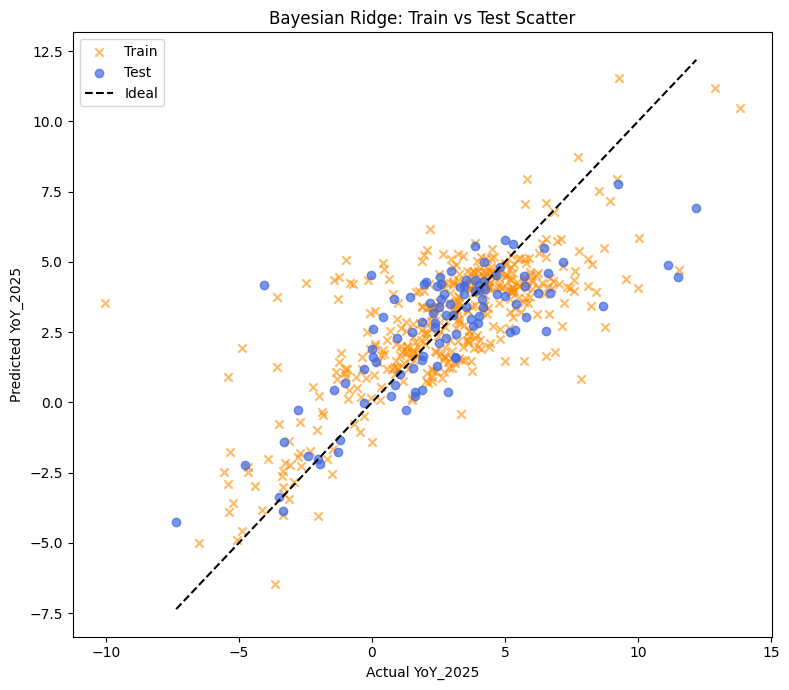

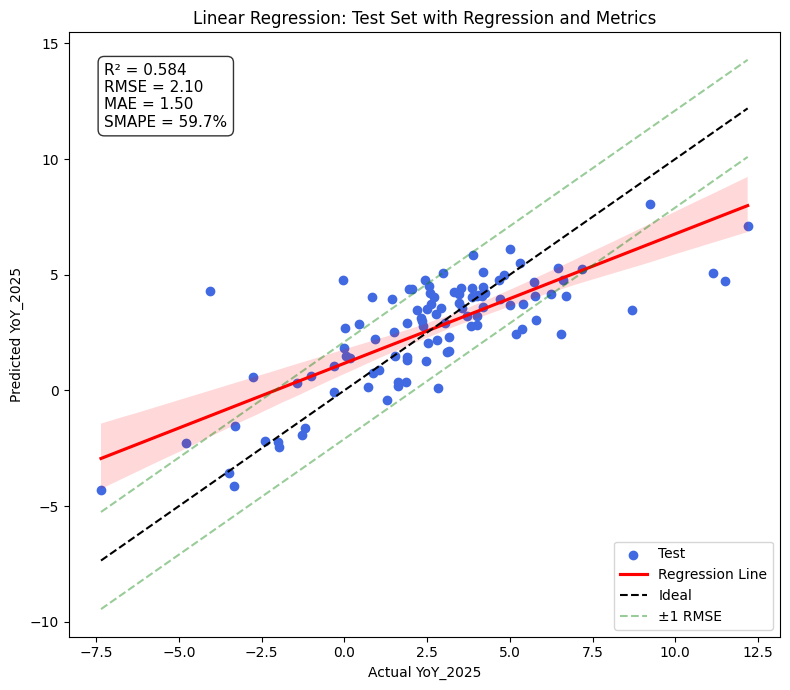

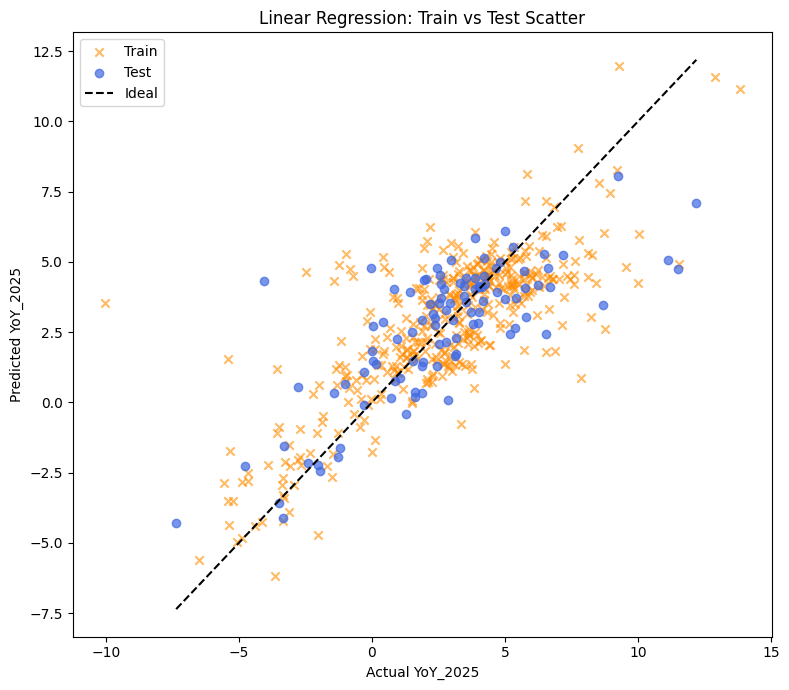

Fitting 5 folds for each of 108 candidates, totalling 540 fits
✅ Best parameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


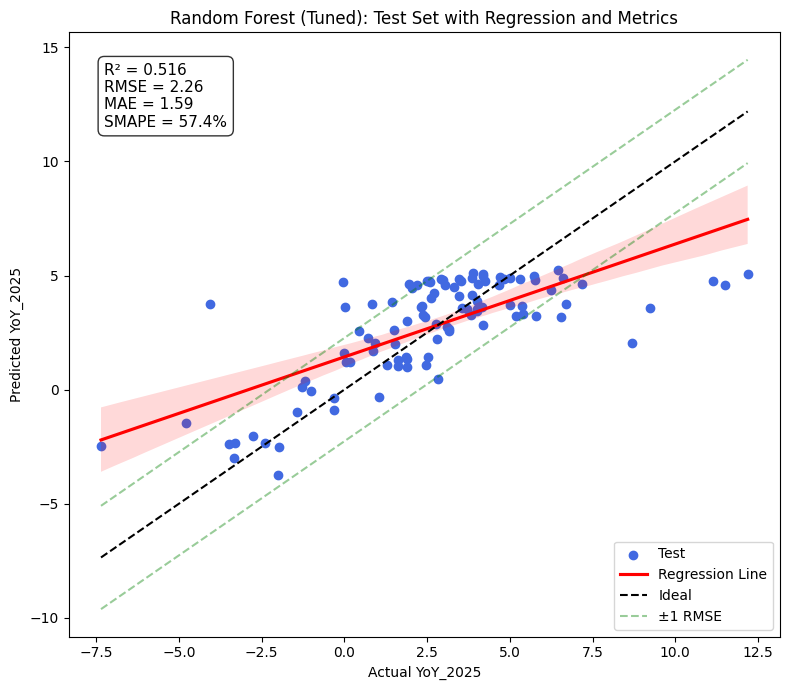

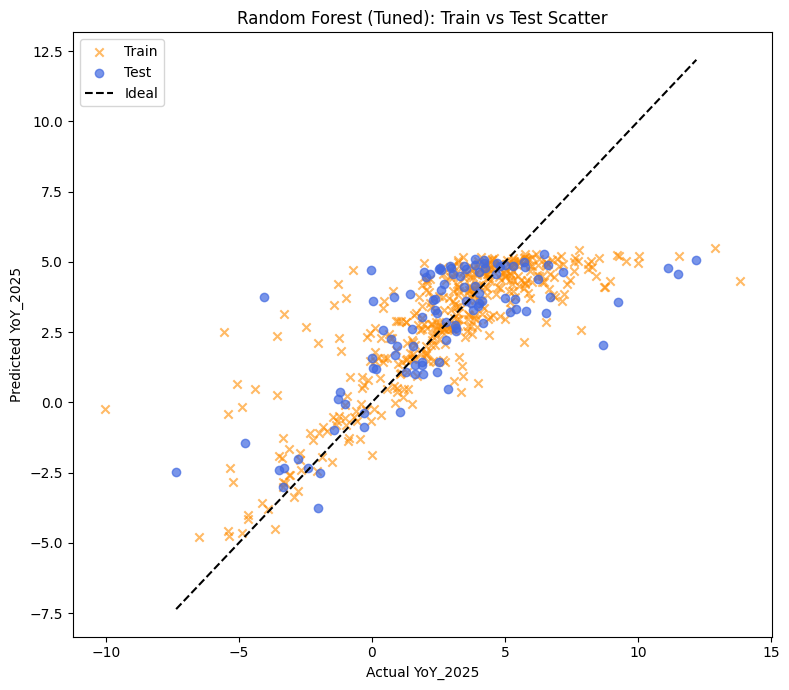

In [17]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# helper function to evaluate regression metrics
def evaluate(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_vals = np.abs(y_true - y_pred) / np.where(denominator == 0, 1, denominator)
    smape = 100 * np.mean(smape_vals)
    return r2, rmse, mae, smape

# models and feature counts (leave RF uninitialized to fit with GridSearch later)
model_configs = {
    "Bayesian Ridge": (BayesianRidge(), 26), #26
    "Linear Regression": (LinearRegression(), 27), #27
    "Random Forest (Tuned)": ("gridsearch", 15) #15
}

for name, (model, k_features) in model_configs.items():
    selector = SelectKBest(score_func=f_regression, k=k_features)
    X_train_sel = selector.fit_transform(X_train_scaled, y_train)
    X_test_sel = selector.transform(X_test_scaled)

    # Handle RF grid search
    if name == "Random Forest (Tuned)":
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }

        rf_base = RandomForestRegressor(random_state=42)
        grid_search = GridSearchCV(
            estimator=rf_base,
            param_grid=param_grid,
            cv=5,
            scoring='r2',
            n_jobs=-1,
            verbose=1
        )
        grid_search.fit(X_train_sel, y_train)
        model = grid_search.best_estimator_
        print(f"✅ Best parameters for Random Forest: {grid_search.best_params_}")

    model.fit(X_train_sel, y_train)

    # predict
    if name == "Bayesian Ridge":
        y_test_pred, y_test_std = model.predict(X_test_sel, return_std=True)
    else:
        y_test_pred = model.predict(X_test_sel)
        y_test_std = np.zeros_like(y_test_pred)

    y_train_pred = model.predict(X_train_sel)
    r2, rmse, mae, smape = evaluate(y_test.values, y_test_pred)

    # Plot 1: Test Predictions
    plt.figure(figsize=(8, 7))
    if name == "Bayesian Ridge":
        plt.errorbar(y_test, y_test_pred, yerr=y_test_std, fmt='o',
                     markersize=5, ecolor='lightblue', capsize=3, color='royalblue', label="Test (±1σ)")
    else:
        plt.scatter(y_test, y_test_pred, color='royalblue', label="Test")

    sns.regplot(x=y_test, y=y_test_pred, scatter=False, color='red', label="Regression Line")

    lims = [min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())]
    plt.plot(lims, lims, 'k--', label='Ideal')
    plt.plot(lims, [l + rmse for l in lims], 'g--', alpha=0.4, label='±1 RMSE')
    plt.plot(lims, [l - rmse for l in lims], 'g--', alpha=0.4)

    metrics_text = (
        f"R² = {r2:.3f}\n"
        f"RMSE = {rmse:.2f}\n"
        f"MAE = {mae:.2f}\n"
        f"SMAPE = {smape:.1f}%"
    )
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
             fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))

    plt.xlabel("Actual YoY_2025")
    plt.ylabel("Predicted YoY_2025")
    plt.title(f"{name}: Test Set with Regression and Metrics")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 2: Train vs Test
    plt.figure(figsize=(8, 7))
    plt.scatter(y_train, y_train_pred, alpha=0.6, marker='x', color='darkorange', label='Train')
    plt.scatter(y_test, y_test_pred, alpha=0.7, marker='o', color='royalblue', label='Test')
    plt.plot(lims, lims, 'k--', label='Ideal')
    plt.xlabel("Actual YoY_2025")
    plt.ylabel("Predicted YoY_2025")
    plt.title(f"{name}: Train vs Test Scatter")
    plt.legend()
    plt.tight_layout()
    plt.show()
